In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
root_dir = '/home1/datawork/zcaspar/mit4320/'
fig_dir = root_dir+ 'Figures_manuscript/'
#Energy
ds_hf = xr.open_dataset(root_dir+'E_hf.nc')
ds_total = xr.open_dataset(root_dir+'E_total.nc')

#Autocovariance
autocov_hf = xr.open_dataset(root_dir+'hf_autocov.nc')
autocov_total = xr.open_dataset(root_dir+'total_autocov.nc')

### Filters + filtered signal

In [12]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

In [13]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [14]:
import scipy.signal as signal
dband = [0.1,0.2,0.3] #0.05,
dt = 1/24
Tw = 30
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

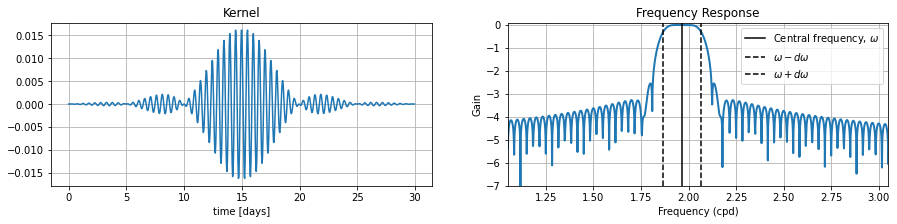

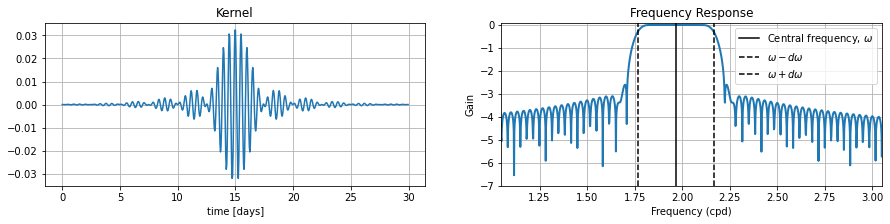

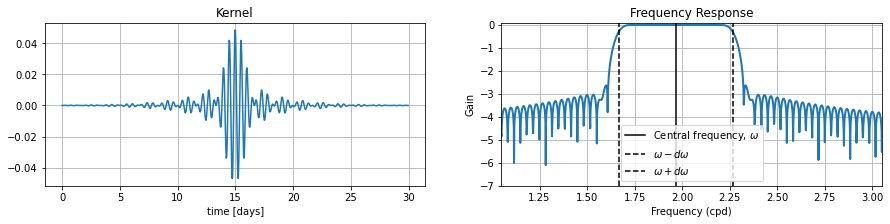

In [15]:
for filt in h.keys():
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    ax.plot(np.arange(0,Tw,dt),h[filt])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')

    ax = axes[1]
    ax.plot(w[filt], np.log10(abs(h_hat[filt])), linewidth=2)
    ax.axvline(omega, color='k',label=r'Central frequency, $\omega$')
    ax.axvline(omega-float(filt),linestyle='--', color='k',label=r'$\omega-d\omega$')
    ax.axvline(omega+float(filt),linestyle='--', color='k',label=r'$\omega+d\omega$')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(1.05, 3.05)
    ax.grid(True)
    ax.legend()
    fig.savefig(fig_dir+'bpass_filt_%s.pdf'%str(np.around(float(filt),decimals=2)))

In [17]:
ds_hf

<xarray.Dataset>
Dimensions:         (T: 4, draw: 500, rms: 4, bandwidth: 3, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * bandwidth       (bandwidth) float64 0.2 0.4 0.6
  * signal          (signal) object 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_demodulated  (bandwidth, signal, rms, T, draw) float64 ...
    MS_demodulated  (bandwidth, signal, rms, T, draw) float64 ...

### Energy estimation

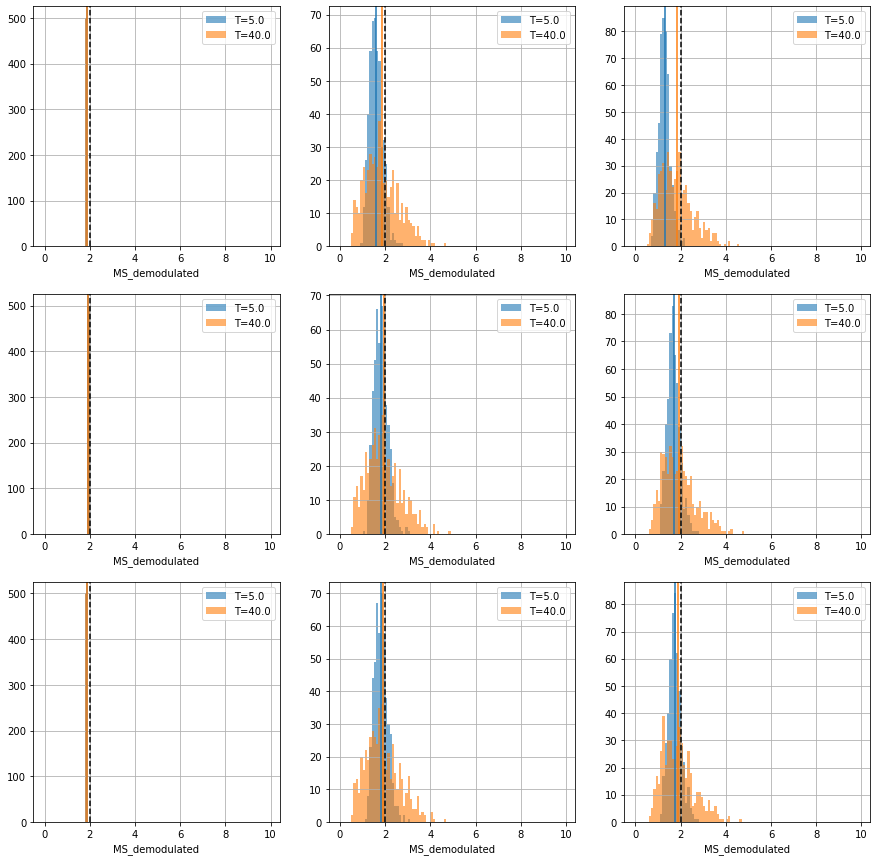

In [33]:
v = 'MS_demodulated'
u = 1
bins = np.arange(0,10,.1)
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        for k,_T in enumerate(_.T):
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
            ax.axvline(_[v].sel(T=_T).mean(), color=f"C{k}")
        ax.legend();
        ax.grid();ax.set_title('');
        ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_estimates_distrib.png')

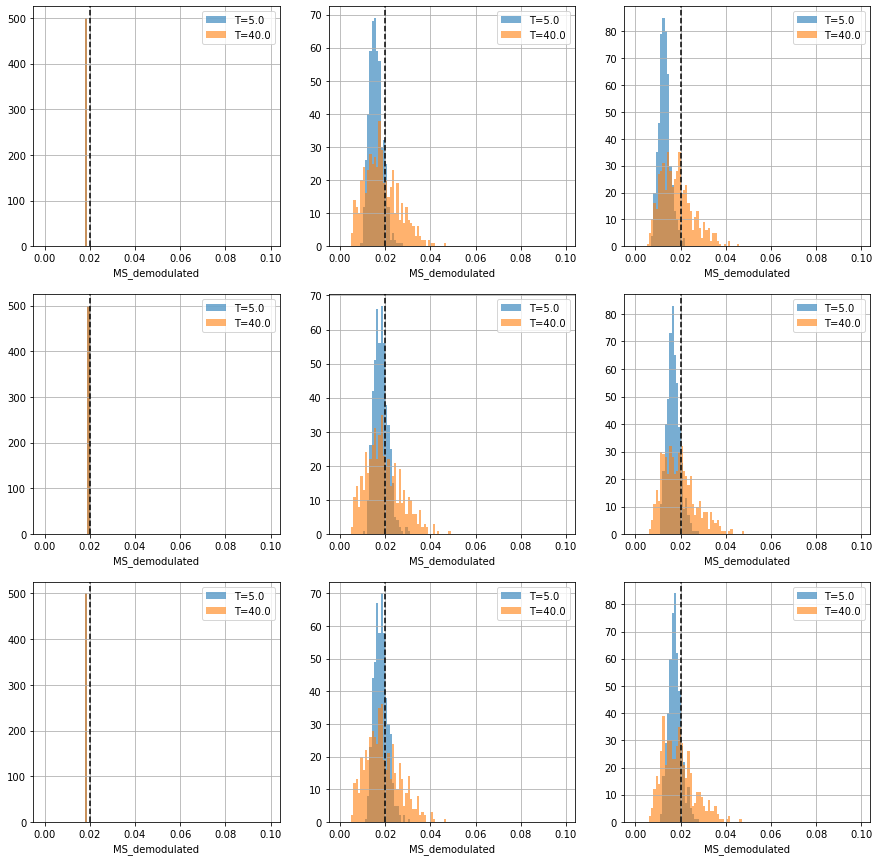

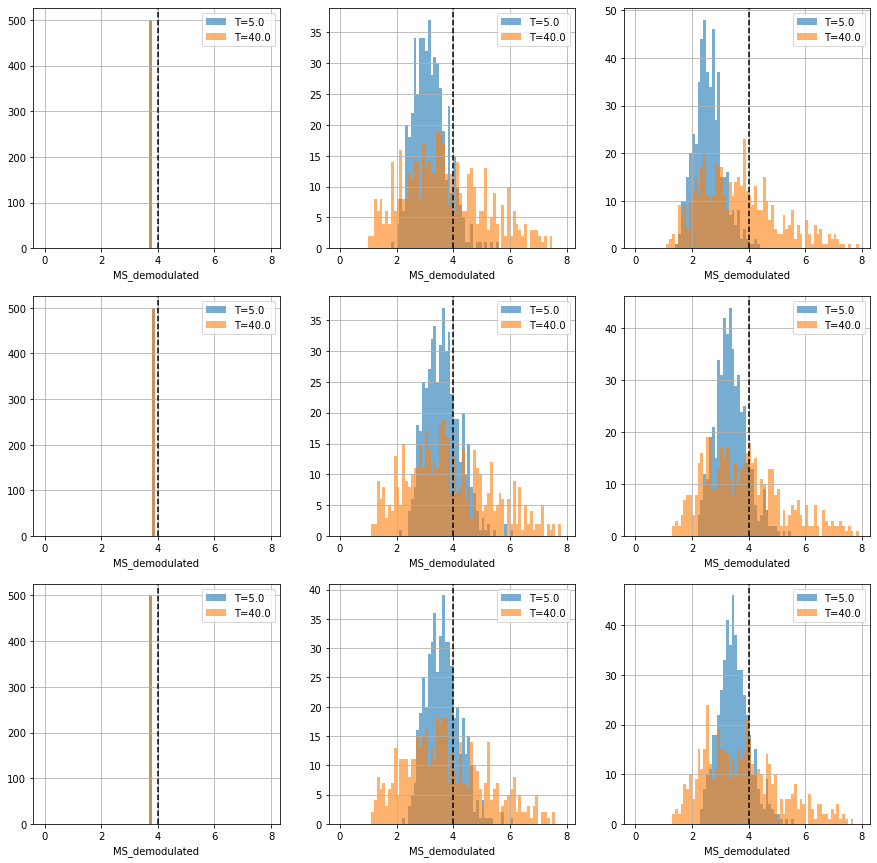

In [29]:
u = 0.01
bins = np.arange(0,0.1,.001)
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        for _T in _.T:
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.legend()
        ax.grid();ax.set_title('')
        ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_estimates_distrib_u001.png')

u = 2
bins = np.arange(0,8,.1)
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=False)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_hf.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        for _T in _.T:
            _[v].sel(T=_T).plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.legend()
        ax.grid();ax.set_title('');
        ax.axvline(2*u,c='k',linestyle='--')
fig.savefig(fig_dir+'bpass_estimates_distrib_u2.png')

### Autocovariance hf only

In [42]:
def th_autocov_M2(tau,V,T):
    return V*np.exp(-tau/T)
def th_autocov_MS(tau,V,T):
    return V*np.exp(-tau/T)*np.cos((omega_S2-omega_M2)*np.pi*tau)
def th_autocov_MS_mixed(tau,V,T):
    return (V*np.exp(-tau/T)+V)*np.cos((omega_S2-omega_M2)*np.pi*tau)
def th_autocov_MS_coh(tau,V,T):
    return V*np.cos((omega_S2-omega_M2)*np.pi*tau)

In [35]:
tau = autocov_hf.lags.values

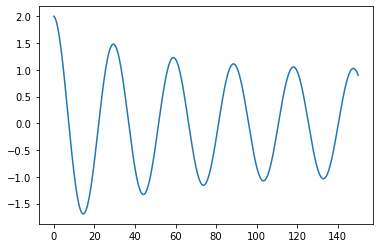

In [36]:
plt.plot(tau,th_autocov_MS_mixed(tau,1,autocov_hf['T'].values[-1]))

In [37]:
ds_mean = autocov_hf.mean('draw')
ds_mean_total = autocov_total.mean('draw')

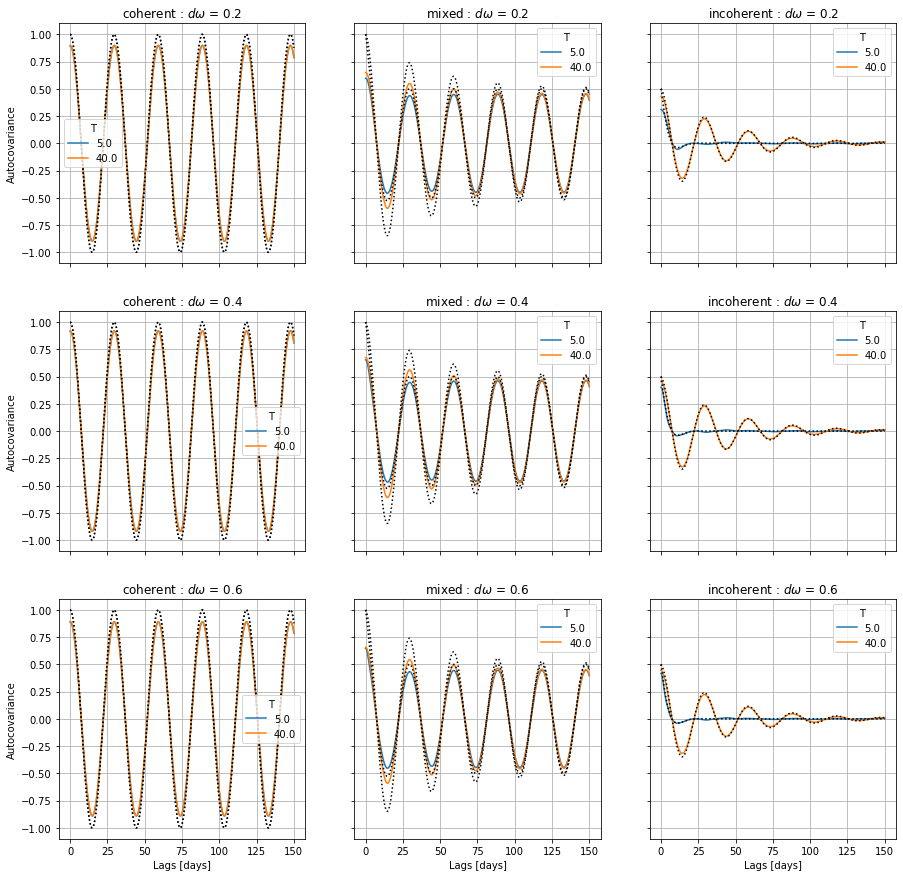

In [49]:
u = 1
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_mean.sel(rms=u,bandwidth=db,signal=s).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u/2,40),c='k',linestyle='dotted')
    
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,5),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u/2,5),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u/2,5),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_hf_u1.png')

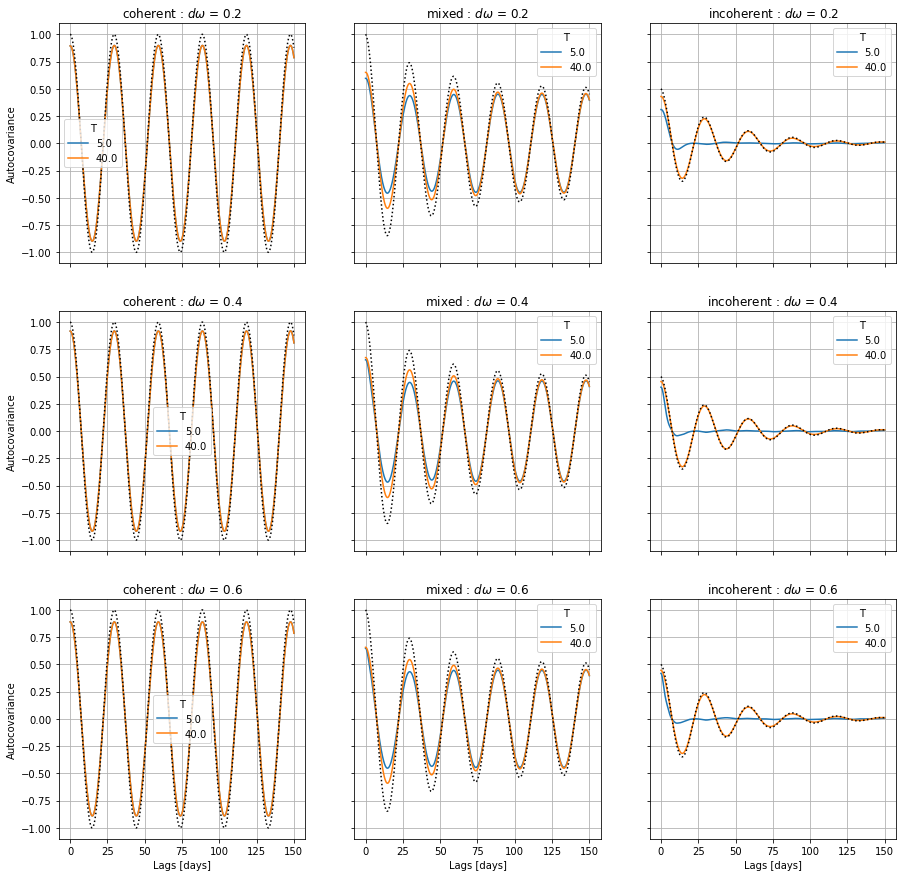

In [53]:
u = 1
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low =20).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u1.png')

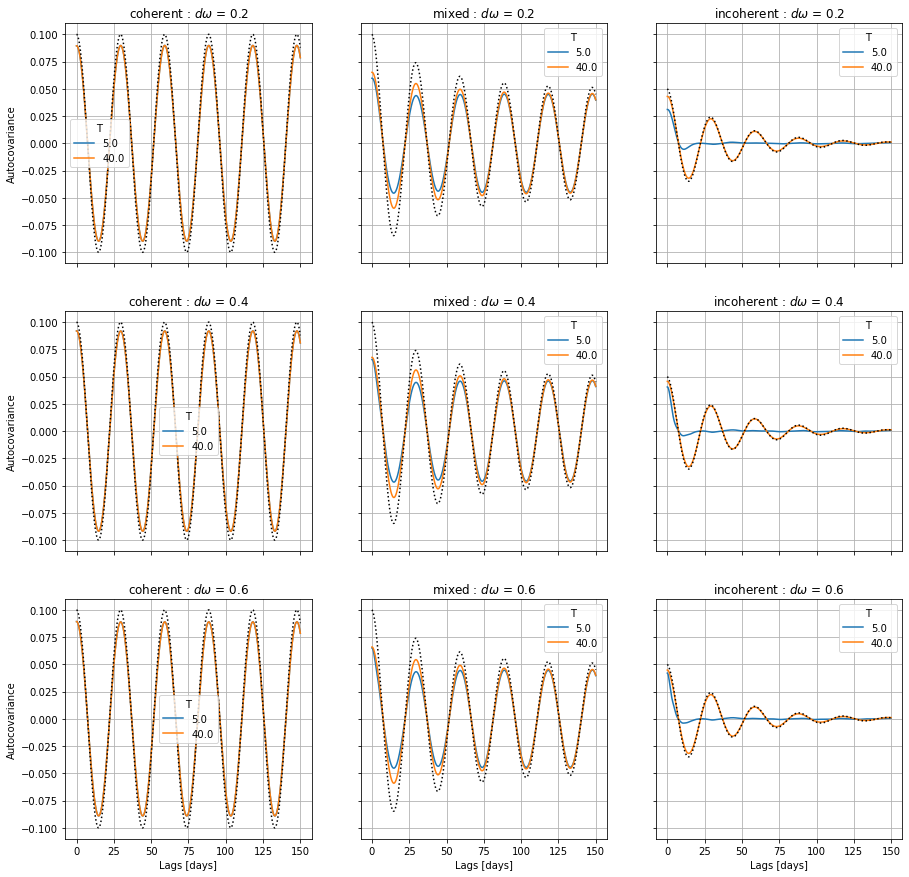

In [55]:
u = 0.1
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low = 20).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u01.png')

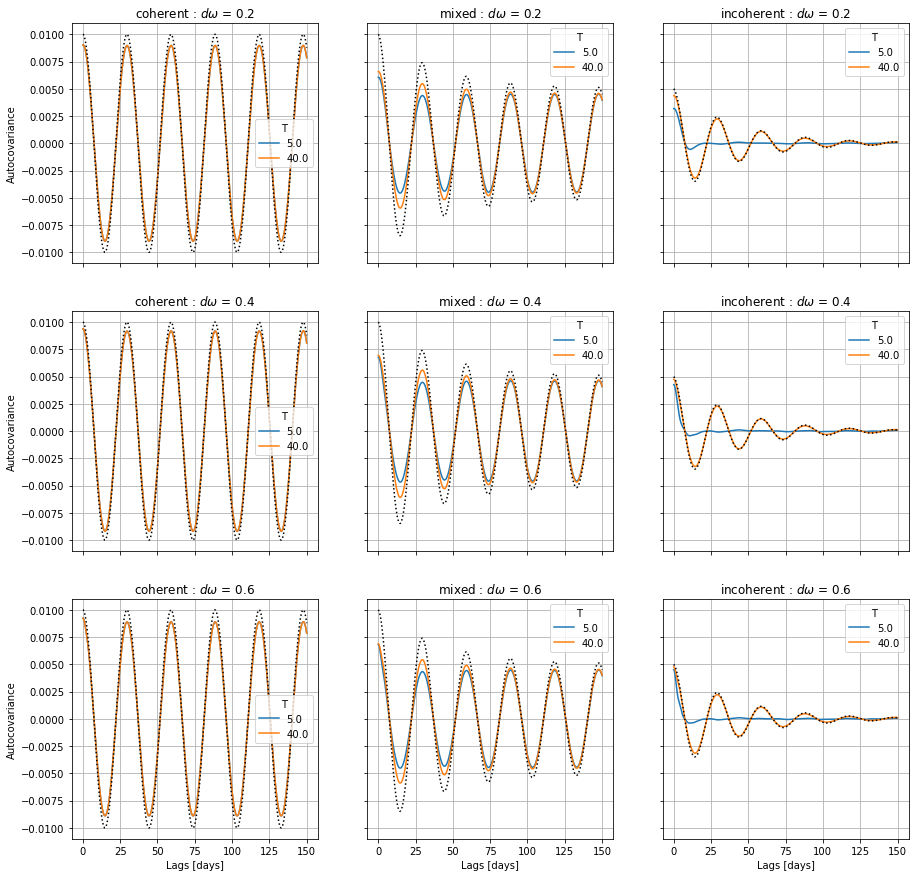

In [57]:
u = 0.01
fig, axs = plt.subplots(ds_hf.bandwidth.size,ds_hf.signal.size, 
                        figsize=(5*ds_hf.signal.size,5*ds_hf.bandwidth.size),sharey=True,sharex=True)
for i,db in enumerate(ds_hf.bandwidth):
    for j, s in enumerate(ds_hf.signal):
        ax = axs[i,j]
        _ = ds_mean_total.sel(rms=u,bandwidth=db,signal=s,T_low = 20).sel(T=[5,40])
        _.MS_real_real.plot(ax=ax,hue='T')
        ax.grid();ax.set_title(r'%s : $d\omega$ = %s'%(s.values,str(db.values)));
        ax.set_ylabel('');ax.set_xlabel('')
    axs[i,0].plot(tau,th_autocov_MS_coh(tau,u,40),c='k',linestyle='dotted')
    axs[i,1].plot(tau,th_autocov_MS_mixed(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,2].plot(tau,th_autocov_MS(tau,u/2,40),c='k',linestyle='dotted')
    axs[i,0].set_ylabel('Autocovariance');
for j in range(3):
    axs[2,j].set_xlabel('Lags [days]')
fig.savefig(fig_dir+'autocov_total_u001.png')

In [58]:
def zero_crossing(data,T,db,s):
    try : 
        out = data.where(np.sign(data).diff('lags')!=0,drop=True).sel(signal=s,bandwidth=db,T=T
                                                                     ).dropna('lags').isel(lags=0)
    except : 
        out = data.isel(lags=-1)
    return out
def wrap(data,T,db,s):
    zero = zero_crossing(data,T,db,s)
    #imin = np.min(0,zero.lags.values)
    #print(zero.lags.values,imin)
#    if zero == data.lags.max()
#        Tbar = xr.DataArray(0,coords={'T':T,'bandwidth':db,'signal':s}).rename('u') #
#    else:
    _ = data.sel(T=T,signal=s,bandwidth=db).sel(lags = slice(0,zero.lags.values))
    Tbar = _.integrate('lags')
    return Tbar#.drop(['T','filt'])

In [93]:
Tbar = {}
for t in ds_mean['T'].values:
    Tbar[t] = xr.combine_nested([[wrap(ds_mean[v],t,db,s) for s in ds_mean['signal'].values
                                 ] for db in ds_mean.bandwidth.values],concat_dim=['bandwidth','signal']
                       )#.assign_coords({'filt':ds_mean['filt'].values})
    Tbar[t] = Tbar[t].assign_coords({'signal':ds_mean.signal.values,'bandwidth':ds_mean.bandwidth.values})

In [92]:
Tbar[t]

<xarray.Dataset>
Dimensions:       (bandwidth: 3, signal: 3)
Coordinates:
    T             float64 40.0
  * bandwidth     (bandwidth) float64 0.2 0.4 0.6
    rms           float64 1.0
  * signal        (signal) object 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_real_real  (signal, bandwidth) float64 67.48 67.48 67.48 ... 19.42 19.42
    MS_real_real  (signal, bandwidth) float64 2.025 2.072 ... 0.3212 0.3205
    M2_real_imag  (signal, bandwidth) float64 0.000126 4.745e-05 ... -0.000892
    MS_real_imag  (signal, bandwidth) float64 0.0008154 0.0003832 ... 0.1117

In [60]:


def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lags.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    
    out = xr.Dataset({'params':(['bandwidth','signal','param'],np.expand_dims(np.expand_dims(params, axis=0),axis=0)),
                      'fitted':(['bandwidth','signal','lags'],np.expand_dims(np.expand_dims(yfit,axis=0),axis=0)),
                     'error' : (['bandwidth','signal','param'],np.expand_dims(np.expand_dims(np.sqrt(np.diag(cov)),axis=0),axis=0))},
                     coords={'bandwidth':np.array([y['bandwidth'].values]),'signal':np.array([y['signal'].values])
                             ,'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lags.values})
    return out#yfit,params,cov

In [61]:

def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lags.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    
    out = xr.Dataset({'params':(['param'],params),
                      'fitted':(['lags'],yfit),
                     'error' : (['param'],np.sqrt(np.diag(cov)))},
                     coords={'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lags.values})
    return out#yfit,params,cov

In [128]:
from inspect import signature
import scipy


# Parameters
myfunc = th_autocov_MS #function to use for the fit
bounds = ((0,0),(1000,2)) # bounds for the fit to avoid non physical results
ce,cl = 'lightseagreen','firebrick'
tau = ds_mean.lags.values

rad = 2*np.pi

In [63]:
import scipy.optimize

In [64]:
ds_mean = ds_mean.sel(rms=1)

In [65]:
s = 'coherent'
db = 0.4
ds_mean.sel(signal=s,T=t)

<xarray.Dataset>
Dimensions:       (bandwidth: 3, lags: 3601)
Coordinates:
    T             float64 40.0
  * bandwidth     (bandwidth) float64 0.2 0.4 0.6
    rms           float64 1.0
    signal        <U8 'coherent'
  * lags          (lags) float64 0.0 0.04167 0.08333 0.125 ... 149.9 150.0 150.0
Data variables:
    M2_real_real  (bandwidth, lags) float64 0.4478 0.4478 ... 0.4493 0.4492
    MS_real_real  (bandwidth, lags) float64 0.8938 0.8939 ... 0.7898 0.7859
    M2_real_imag  (bandwidth, lags) float64 -0.0001012 -0.0001043 ... 0.000174
    MS_real_imag  (bandwidth, lags) float64 -0.0001497 -0.0001411 ... 0.0005645

In [118]:
def yfit_inc(tau,Tbar,V):
    return V*np.exp(-tau/Tbar)*np.cos(omega*rad*tau)

In [119]:
omega

1.9661368071336223

In [94]:
v = 'MS_real_real'
s = 'incoherent'
Tbar_fit = {}
for t_ in ds_mean['T'].values:
    print(t_)
    Tbar_fit[t_] = xr.combine_nested([[fit(tau,ds_mean[v].sel(bandwidth=db,signal=s,T=t_),myfunc,bounds,norm=False
                             ) for db in ds_mean['bandwidth'].values[:]] for s in ds_mean['signal']
                                    ],concat_dim=['signal','bandwidth']
                        )
    Tbar_fit[t_] = Tbar_fit[t_].assign_coords({'signal':ds_mean.signal.values,'bandwidth':ds_mean.bandwidth.values})
#.assign_coords({'filt':ds_mean['filt'].values})

5.0
10.0
20.0
40.0


In [106]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['bandwidth','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['bandwidth','lags'],np.expand_dims(yfit,axis=0)),
                     'error' : (['bandwidth','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'bandwidth':np.array([y['bandwidth'].values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lags.values})
    return out#yfit,params,cov

In [111]:
xr.concat([fit(tau,ds_mean[v].sel(bandwidth=db,signal=s,T=t_),myfunc,bounds,norm=False
                             ) for db in ds_mean['bandwidth'].values[:]],dim='bandwidth)

SyntaxError: EOL while scanning string literal (789934354.py, line 2)

In [129]:
Tbar_fit = {}
s = 'incoherent'
for t_ in ds_mean['T'].values:
    print(t_)
    Tbar_fit[t_] = xr.concat([fit(tau,ds_mean[v].sel(bandwidth=db,signal=s,T=t_),myfunc,bounds,norm=False
                             ) for db in ds_mean['bandwidth'].values[:]],dim='bandwidth')
    Tbar_fit[t_] = Tbar_fit[t_].assign_coords({'bandwidth':ds_mean.bandwidth.values})
#.assign_coords({'filt':ds_mean['filt'].values})

5.0
10.0
20.0
40.0


In [114]:
true_Tbar = ds_mean['T']

In [102]:
Tbar[5]

<xarray.DataArray 'MS_real_real' (signal: 3, bandwidth: 3)>
array([[4.28376622, 4.38090797, 4.24743408],
       [2.79877149, 2.83026131, 2.75256112],
       [1.37018887, 1.33609791, 1.31269259]])
Coordinates:
    T          float64 5.0
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6
    rms        float64 1.0
  * signal     (signal) object 'coherent' 'mixed' 'incoherent'

In [ ]:
Tbar

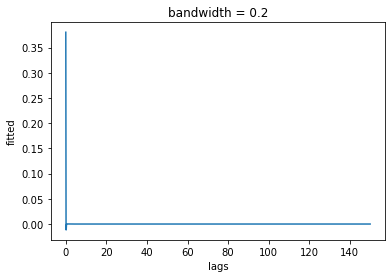

In [127]:
Tbar_fit[5].fitted.sel(bandwidth=0.2).plot(x='lags')


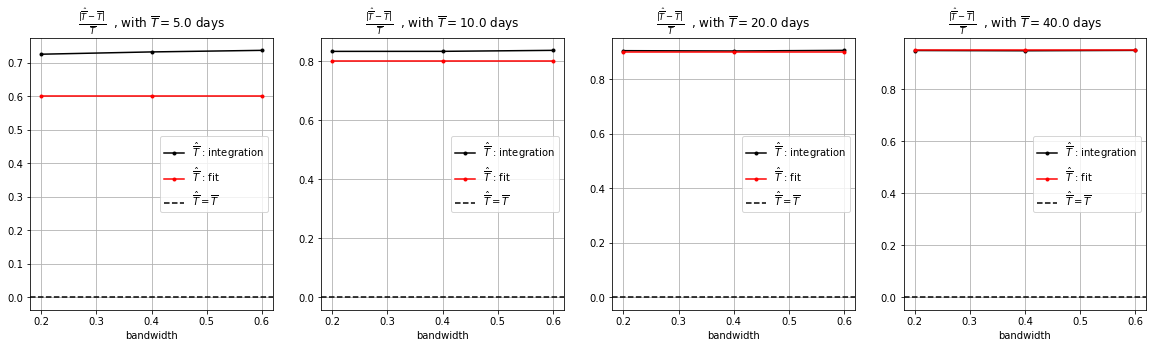

In [131]:
s = 'incoherent'
fig,ax = plt.subplots(1,ds_hf['T'].size,figsize=(5*ds_hf['T'].size,5))
for i,t in enumerate(ds_mean['T'].values):
    Tb = Tbar[t].sel(signal=s)#.values
    Tb_fit = Tbar_fit[t].sel(param='T').params#.values
    (abs(Tb-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
    ).plot(ax=ax[i],c = 'k',marker='.',label=r'$\hat{\overline{T}}$ : integration');
    (abs(Tb_fit-true_Tbar.sel(T=t))/true_Tbar.sel(T=t)
     ).plot(ax=ax[i],c = 'r',marker='.',label=r'$\hat{\overline{T}}$ : fit');
    ax[i].grid();ax[i].axhline(0,c='k',linestyle='--',label=r'$\hat{\overline{T}} = \overline{T}$');
   # ax[i].set_title(r'True decorrelation timescale , $\overline{T}$ : %s days'%str(t));
    ax[i].set_title(r'$\frac{\vert\hat{\overline{T}}-\overline{T}\vert}{\overline{T}}$  , with $\overline{T}=$%s days'%str(t));
    ax[i].legend();
    
fig.savefig(fig_dir+'hf_Tbar.png')